# Low-order model and Channel simulation comparison

\begin{equation} \frac{dE}{dt} = \mathcal X E  \end{equation}
\begin{equation}  \rightarrow E = e^{\pm i \omega t} \text{    where   } \omega = \sqrt{ab/2} \end{equation}

In [1]:
import numpy as np
from matplotlib import rc
#rc('text', usetex=True)
rc('xtick', labelsize=40) #20 
rc('ytick', labelsize=40) #20
rc('axes', titlesize=40)    # fontsize of the axes title
rc('axes', labelsize=40) #24  
rc('font', **{'size':40})
import matplotlib.pyplot as plt

In [2]:
H =  3000 #ASC[m]  ### ACC rho = 1026.89 drho = 1.2 H  = 2000 
#ACC values -- give freq of 420days but ACC so dynamics will be differnt!
drho = 0.1 #original--> before used 0.5 for diff relative to AABW layer
Hrho = 1000 ## combined height of top two layers to use for buoyancy frequency calculation

drho_dz = -drho/(Hrho/2)
f = -1e-4
g = 9.81
rho0 = 1027.8 #[kg/m^3
tau = 0.05
gp = drho/rho0 *g
print(gp)
#htop = 200 #[m] height of top layer thickness

Nsquared = - g/rho0 * drho_dz

0.0009544658493870405


In [3]:
Nsquared

1.908931698774081e-06

In [4]:
Ly = 200e3 #np.sqrt(Nsquared) * H /f #2e4 #7e3 #rossby deformation radius
print(Ly)

a = (2* abs(f) *gp /(f*np.sqrt(Nsquared)*H)) *np.sqrt(6/(rho0*gp*Ly**3))
a = (2 *gp /(np.sqrt(Nsquared)*H)) *np.sqrt(6/(rho0*gp*Ly**3))

a

200000.0


1.2734153133564038e-11

In [5]:
b = (2*tau*gp*Ly/f) *np.sqrt(6/(rho0*gp*Ly**3))
b = (2*tau*gp*Ly/abs(f)) *np.sqrt(6/(rho0*gp*Ly**3))

b

0.005278208207829867

In [6]:
T = 2*np.pi/np.sqrt(a*b/2)/ (60*60*24)
T

396.6914414938687

In [7]:
#functions to predict APE and E based on low-order model

In [8]:
def MAPE_predict(cdrag):
    a = (2* abs(f) *gp /(f*np.sqrt(Nsquared)*H)) *np.sqrt(6/(rho0*gp*Ly**3))
    a = (2 *gp /(np.sqrt(Nsquared)*H)) *np.sqrt(6/(rho0*gp*Ly**3))

    MAPE  = (cdrag/a)**2
    print(cdrag, MAPE)
    return MAPE

In [9]:
def E_predict(tau):
    b = (2*tau*gp*Ly/f) *np.sqrt(6/(rho0*gp*Ly**3))
    a = (2* abs(f) *gp /(f*np.sqrt(Nsquared)*H)) *np.sqrt(6/(rho0*gp*Ly**3))
    E = b/a
    return E

In [10]:
def period(tau, Ly):
    omega = np.sqrt(12 * gp * abs(f)* tau) /(rho0 * f * Ly) / (np.sqrt(np.sqrt(Nsquared)*H))
    
    omega = np.sqrt(12 * gp * abs(f)* tau ) /( f * Ly) 
    omega = omega / (np.sqrt(np.sqrt(Nsquared)*H* rho0))
    T = 2*np.pi/omega / (60*60*24)

    return abs(T)

In [11]:
#import nc files of fft period

In [12]:
import xarray as xr
import netCDF4 as nc

In [13]:
from dask.distributed import Client

c=Client(local_directory = '/scratch/e14/qo9901/') 
c 

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43279,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:38793,Total threads: 1
Dashboard: /proxy/35195/status,Memory: 50.00 GiB
Nanny: tcp://127.0.0.1:46319,


In [14]:
import gc
c.run(gc.collect)

{'tcp://127.0.0.1:36073': 52,
 'tcp://127.0.0.1:37207': 52,
 'tcp://127.0.0.1:38793': 52,
 'tcp://127.0.0.1:39811': 52}

In [15]:
#import matrix with period of oscillation

In [16]:
period_CDW_drag_EKE_ds = xr.open_mfdataset('/g/data/v45/qo9901/layeredASFpaper_ncfile_all/period_CDW_drag_EKE_full.nc', combine='by_coords',  chunks={"Time": 1000},decode_times=False, engine='netcdf4', parallel=True) #, decode_times=False,
period_CDW_wind_EKE_ds = xr.open_mfdataset('/g/data/v45/qo9901/layeredASFpaper_ncfile_all/period_CDW_wind_EKE_full.nc', combine='by_coords',  chunks={"Time": 1000},decode_times=False, engine='netcdf4', parallel=True) #, decode_times=False,

In [17]:
period_CDW_drag_EKE = period_CDW_drag_EKE_ds.value.load().values
period_CDW_wind_EKE = period_CDW_wind_EKE_ds.value.load().values


(0.0, 2000.0)

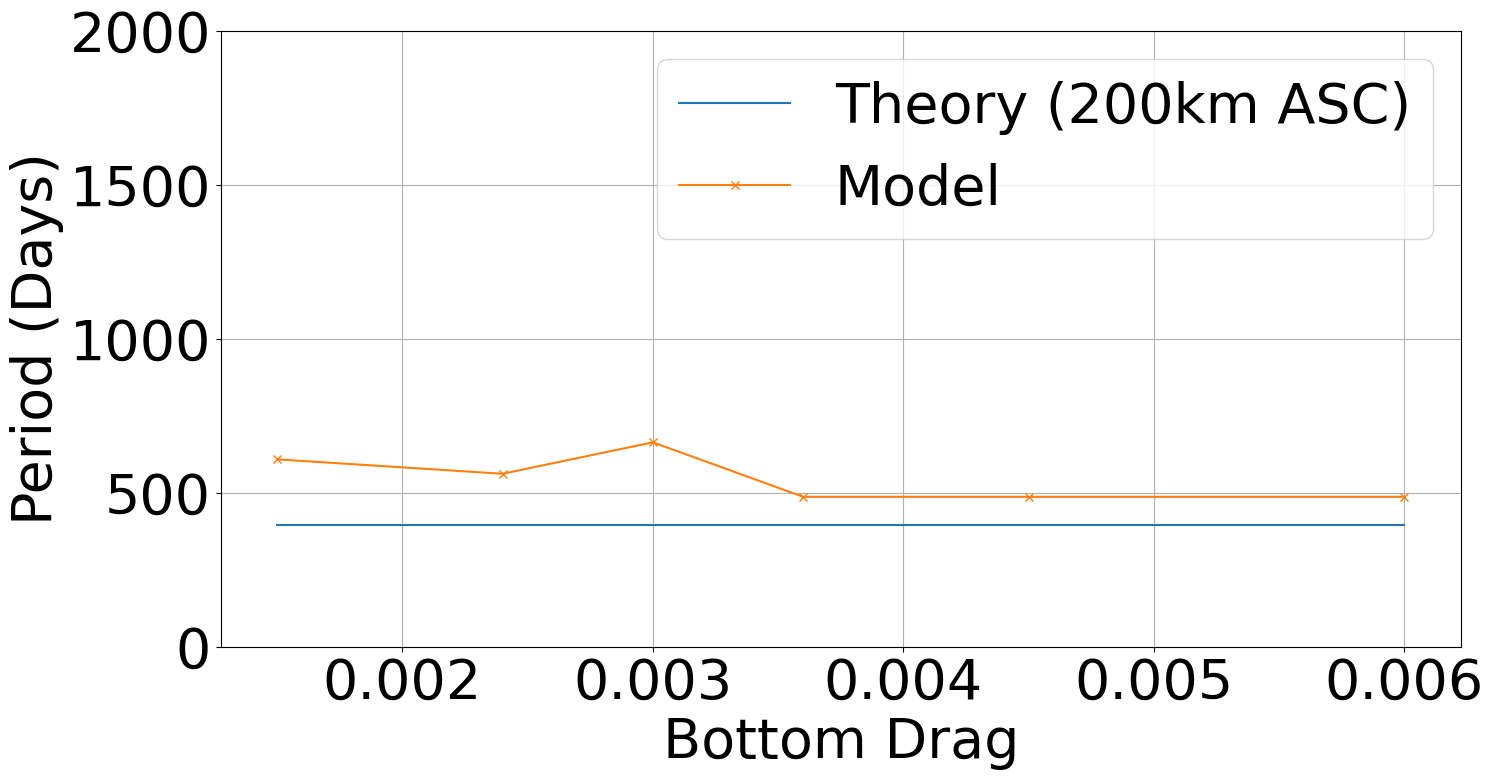

In [18]:
drag_matrix = np.asarray([1.5e-3,2.4e-3, 3e-3,3.6e-3,4.5e-3,6e-3])
plt.figure(figsize = (16,8))
plt.plot(drag_matrix, T*np.ones(len(drag_matrix)), label = 'Theory (200km ASC)')
plt.plot(drag_matrix, period_CDW_drag_EKE, label = 'Model', marker = 'x')
plt.ylabel('Period (Days)')
plt.xlabel('Bottom Drag')
plt.legend()
plt.grid(which  = 'both')

plt.ylim([400,2400])
plt.ylim([0,2000])

(0.0, 2000.0)

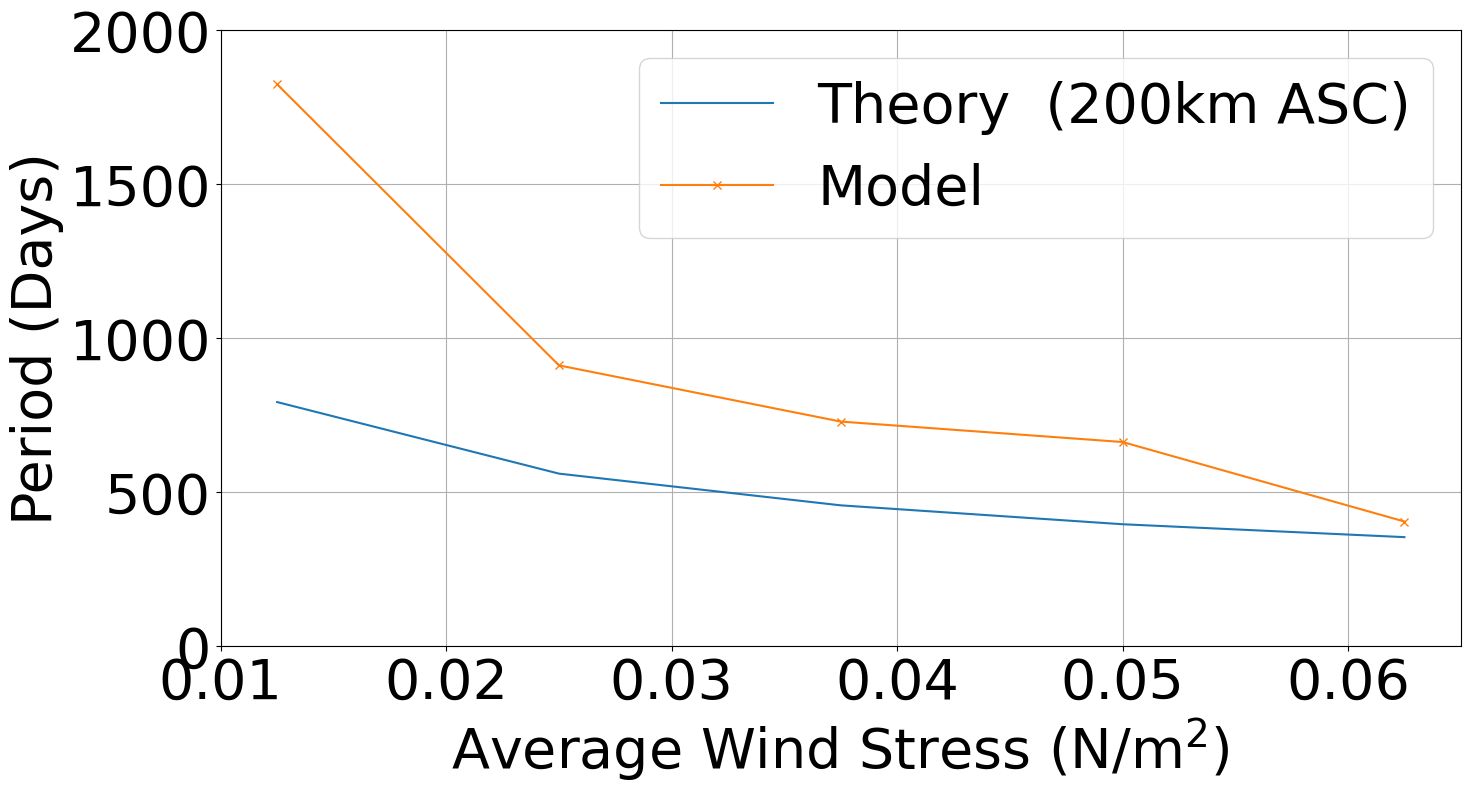

In [19]:
tau_matrix = np.asarray([0.025,0.05,0.075,0.1,0.125])/2
Ly_matrix = np.asarray(np.ones(len(tau_matrix))*Ly)
plt.figure(figsize = (16,8))
T_matrix = [period(tau_matrix[i], Ly_matrix[i]) for i in range(len(tau_matrix))]
plt.plot(tau_matrix, T_matrix, label = 'Theory  (200km ASC)')
plt.plot(tau_matrix, period_CDW_wind_EKE, label = 'Model', marker = 'x')
plt.ylabel('Period (Days)')
plt.xlabel('Average Wind Stress (N/m$^{2}$)')
plt.legend()
plt.grid(which  = 'both')
#plt.ylim([400,2400])
plt.ylim([0,2000])

In [20]:
print(T_matrix)
print(period_CDW_wind_EKE)

[793.3828829877374, 561.006416637962, 458.0598210634115, 396.6914414938687, 354.8116117090685]
[1825.       912.5      730.       663.63635  405.55554]


In [24]:
#importing computed APE in CDW layer
magnitude_drag_APE_cdw_ds = xr.open_mfdataset('/g/data/v45/qo9901/layeredASFpaper_ncfile_all/magnitude_drag_APE_cdwonly_relsponging.nc', combine='by_coords',  chunks={"Time": 1000},decode_times=False, engine='netcdf4', parallel=True) #, decode_times=False,
magnitude_wind_APE_cdw_ds = xr.open_mfdataset('/g/data/v45/qo9901/layeredASFpaper_ncfile_all/magnitude_wind_APE_cdwonly_relsponging.nc', combine='by_coords',  chunks={"Time": 1000},decode_times=False, engine='netcdf4', parallel=True) #, decode_times=False,
#magnitude_drag_MAPE_cdw.nc
magnitude_drag_APE_cdw = magnitude_drag_APE_cdw_ds.value.load().values
magnitude_wind_APE_cdw = magnitude_wind_APE_cdw_ds.value.load().values

[2.5e-07 4.0e-07 5.0e-07 6.0e-07 7.5e-07 1.0e-06]
2.5e-07 385425000.00000006
4e-07 986688000.0
5e-07 1541700000.0000002
6e-07 2220048000.0
7.5e-07 3468825000.000001
1e-06 6166800000.000001


(-10000000.0, 6500000000.0)

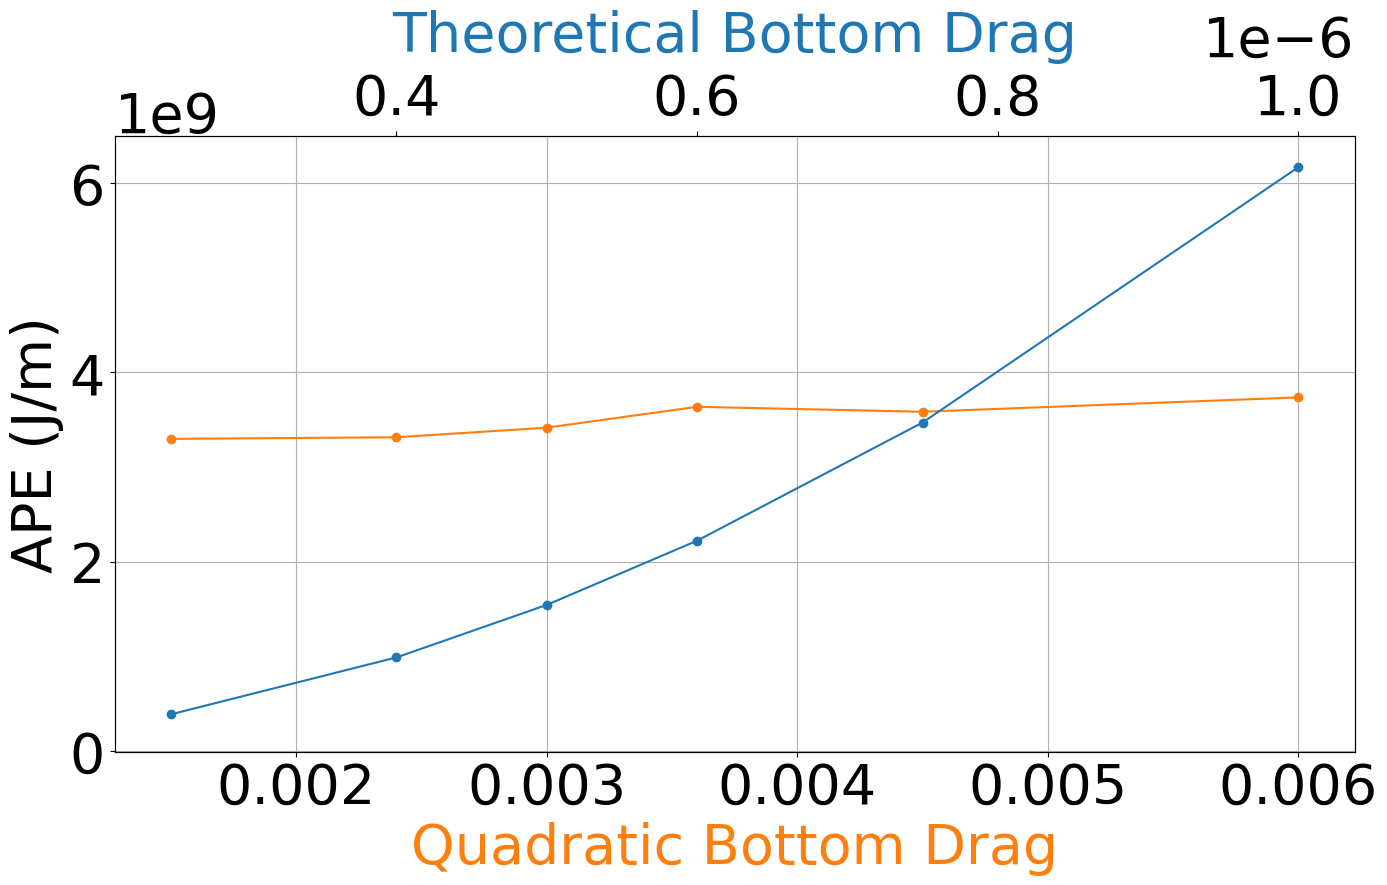

In [25]:
drag_matrix = np.asarray([1.5e-3, 2.4e-3,3e-3,3.6e-3,4.5e-3,6e-3])*1e-5
cdrag_new = 5e-7
drag_matrix = np.asarray([cdrag_new*0.5,cdrag_new*0.8,cdrag_new,cdrag_new*1.2,cdrag_new*1.5,cdrag_new*2])
print(drag_matrix)## CHECK THE UNITS THAT EKE ARE IN IN THE DATA+BASE
plt.figure(figsize = (16,8))
ax1 = plt.subplot()
APE_cdw_drag_predict_matrix = [MAPE_predict(drag_matrix[i]) for i in range(len(drag_matrix))] ## APE ~ O(1e7)
drag_plot_matrix = np.asarray([1.5e-3, 2.4e-3,3e-3,3.6e-3,4.5e-3,6e-3]) ## CHECK THE UNITS THAT EKE ARE IN IN THE DATA+BASE
ax2 = ax1.twiny()

ax2.plot(drag_matrix, APE_cdw_drag_predict_matrix, label = 'Theory (200km ASC)', marker = 'o')
#plt.plot(drag_plot_matrix, np.asarray([3.952531e+08, 1.016263e+09, 1.572045e+09, 2.249446e+09,3.613775e+09,6.074820e+09,]), label = 'Theory IVP (200km ASC)') #old but whatever
ax1.plot(drag_plot_matrix, magnitude_drag_APE_cdw, label = 'Experiments', marker = 'o', color = 'C1') #*1e6 is old APE cdw
## MAPE calculates and saves as sum over xh and yh,dx, dy contribution in the xgcm?
## to get the mean in longitudinal direction - nc_file len_x
## len_x  = 1000km
## 
ax1.set_ylabel('APE (J/m)')
ax2.set_xlabel('Theoretical Bottom Drag', color = 'C0', labelpad = 15)
ax1.set_xlabel('Quadratic Bottom Drag', color = 'C1')
ax1.grid(which  = 'both')
plt.ylim([-0.01e9,6.5e9])

5e-07 1541700000.0000002


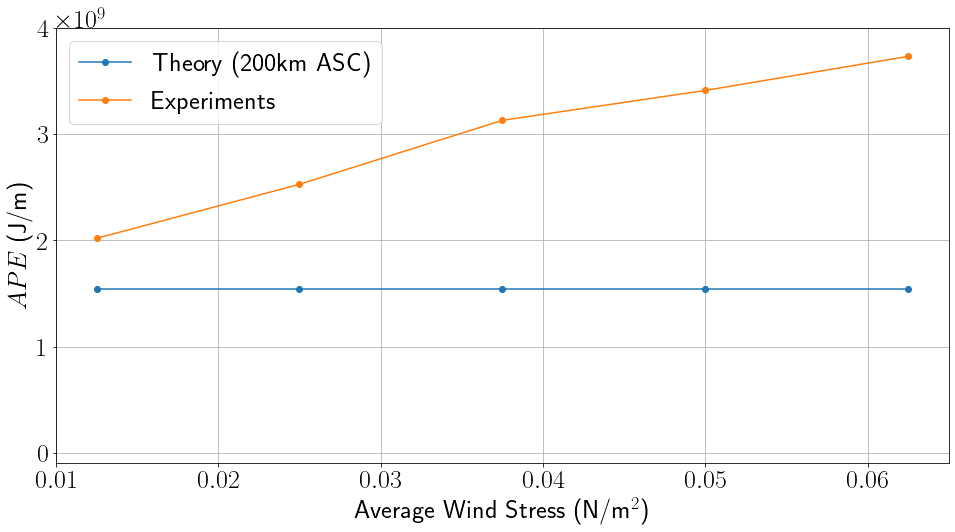

In [36]:
tau_matrix = np.asarray([0.025,0.05,0.075,0.1, 0.125])/2
plt.figure(figsize = (16,8))
T_matrix = np.ones(len(tau_matrix))*MAPE_predict(5e-7)

#plt.ylim([400,2400])
#plt.ylim([0,2400])
#plt.ylim([0,5e9])


plt.plot(tau_matrix, T_matrix, label = 'Theory (200km ASC)', marker = 'o', color = 'C0')
#plt.plot(tau_matrix, np.asarray([1.544042e+09,1.572045e+09,1.594390e+09,1.571158e+09,1.590986e+09]), label = 'Theory IVP (200km ASC)', color = 'C0')

#ax1.set_ylim([-0.1e11,0.9e11])
#ax1.set_yticks(np.arange(-0.1e11, 0.9e11, 1e10))
plt.ylabel(' $APE$ (J/m)')

plt.plot(tau_matrix, magnitude_wind_APE_cdw, label = 'Experiments', marker = 'o', color = 'C1')
plt.xlabel('Average Wind Stress (N/m$^2$)')
plt.grid(which  = 'both')
plt.ylim([-0.1e9,4e9])
plt.legend()

In [19]:
E_drag_ds = xr.open_mfdataset('/g/data/v45/qo9901/layeredASFpaper_ncfile_all/magnitude_drag_totalenergy_relsponging.nc', combine='by_coords',  chunks={"Time": 1000},decode_times=False, engine='netcdf4', parallel=True) #, decode_times=False,
E_wind_ds = xr.open_mfdataset('/g/data/v45/qo9901/layeredASFpaper_ncfile_all/magnitude_wind_totalenergy_relsponging.nc', combine='by_coords',  chunks={"Time": 1000},decode_times=False, engine='netcdf4', parallel=True) #, decode_times=False,

In [20]:
E_drag = E_drag_ds.value.load().values
E_wind = E_wind_ds.value.load().values


(-100000000.0, 2000000000.0)

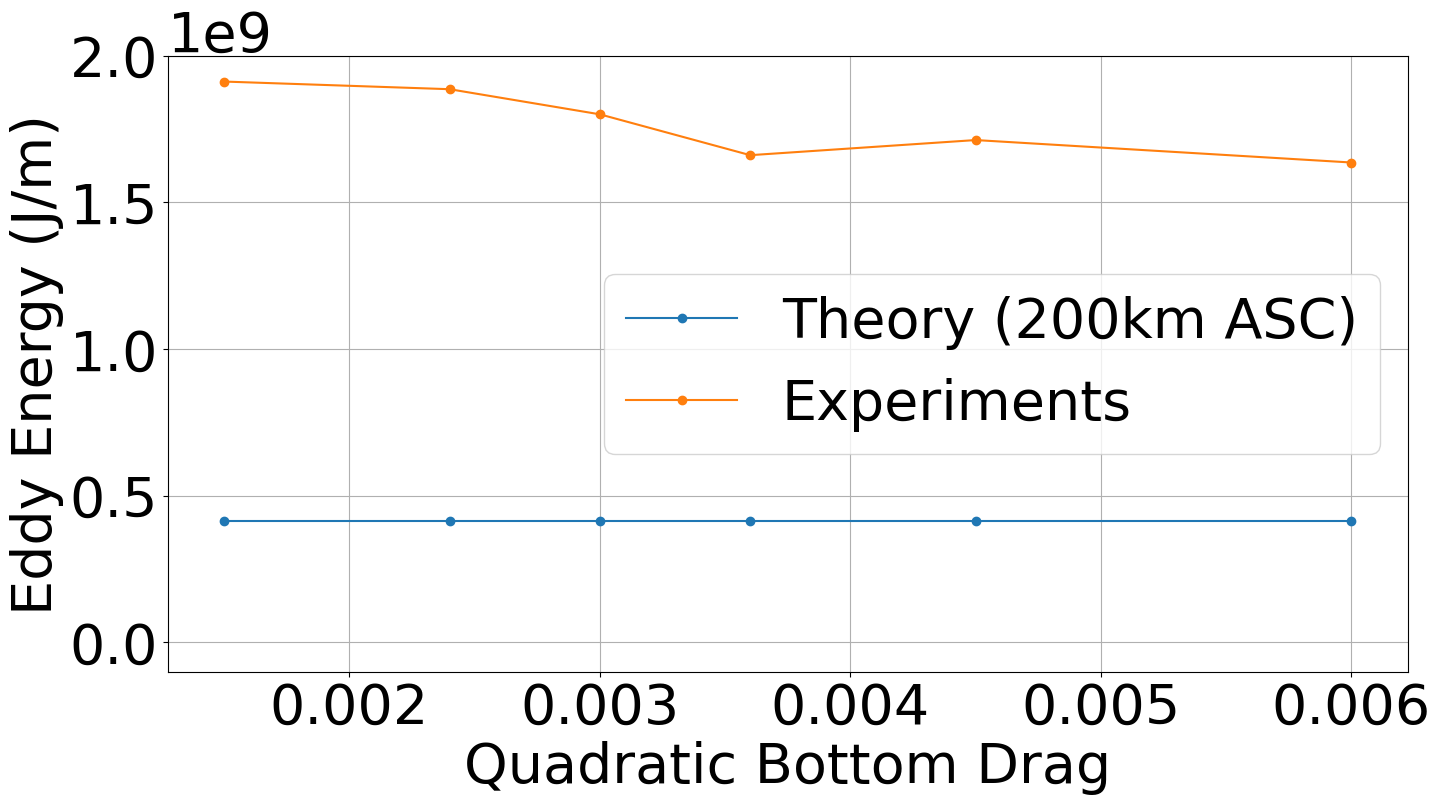

In [22]:
drag_plot_matrix = np.asarray([1.5e-3, 2.4e-3, 3e-3, 3.6e-3,4.5e-3,6e-3]) ## CHECK THE UNITS THAT EKE ARE IN IN THE DATA+BASE
cdrag_new = 5e-7
drag_matrix = np.asarray([cdrag_new*0.5,cdrag_new*0.8,cdrag_new,cdrag_new*1.2,cdrag_new*1.5,cdrag_new*2])

plt.figure(figsize = (16,8))
Edrag_predict_matrix = np.ones(len(drag_matrix))*E_predict(0.1/2)
plt.plot(drag_plot_matrix, Edrag_predict_matrix, label = 'Theory (200km ASC)', marker = 'o')
#plt.plot(drag_matrix, np.ones(len(drag_matrix))*np.asarray([4.144923e+08]), label = 'Theory IVP (200km ASC)')

plt.plot(drag_plot_matrix, E_drag, label = 'Experiments', marker = 'o')
plt.ylabel('Eddy Energy (J/m)')
plt.xlabel('Quadratic Bottom Drag')
plt.legend()
#plt.ylim([0,5e9])
plt.grid(which  = 'both')
plt.ylim([-.1e9,2e9])

(-100000000.0, 2000000000.0)

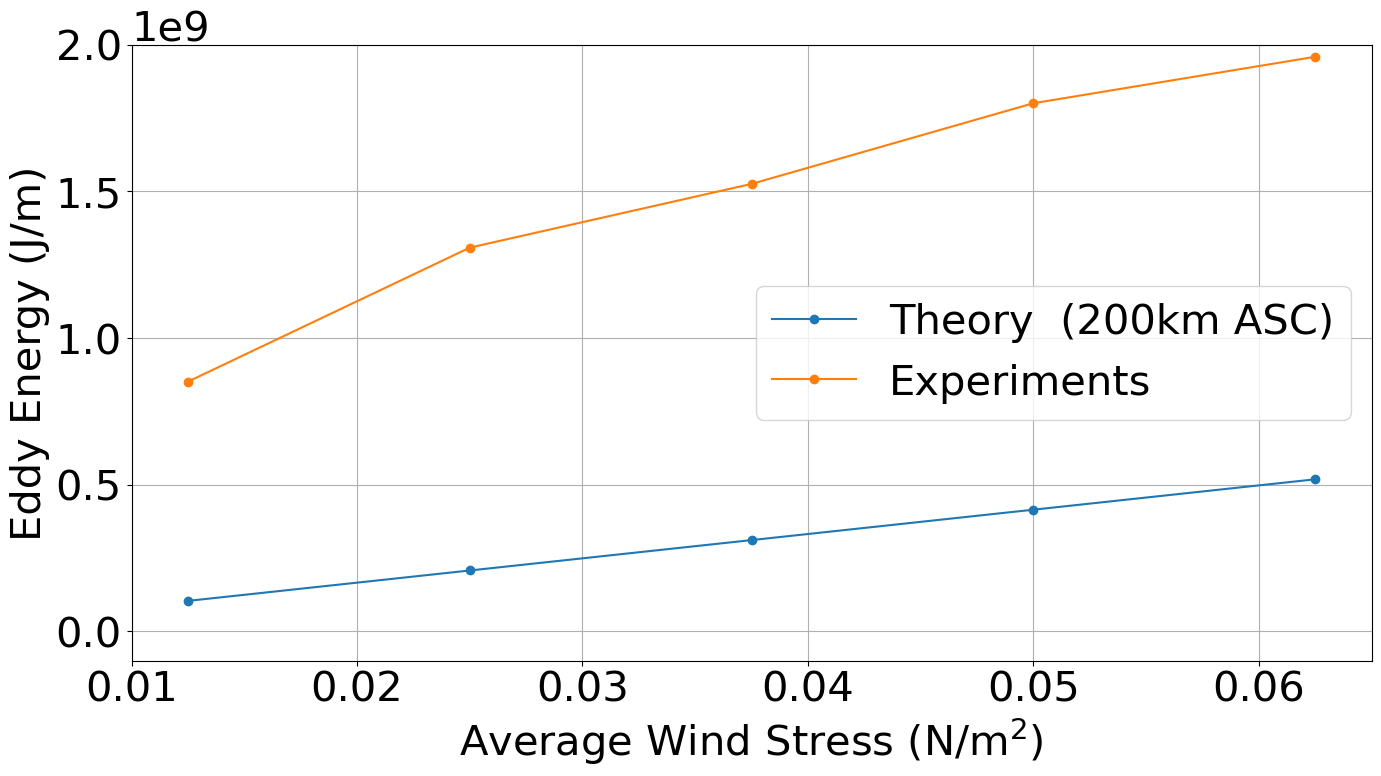

In [33]:
tau_matrix = np.asarray([0.025,0.05,0.075,0.1,0.125])/2
plt.figure(figsize = (16,8))
T_matrix = [E_predict(tau_matrix[i]) for i in range(len(tau_matrix))]
plt.plot(tau_matrix, T_matrix,marker = 'o', label = 'Theory  (200km ASC)')
#plt.plot(tau_matrix, np.asarray([1.036231e+08,2.072461e+08,3.108692e+08,4.144923e+08,5.181154e+08]), label = 'Theory IVP (200km ASC)')

plt.plot(tau_matrix, E_wind, label = 'Experiments', marker = 'o')
plt.ylabel('Eddy Energy (J/m)')
plt.xlabel('Average Wind Stress (N/m$^{2}$)')
plt.legend()
#plt.ylim([400,2400])
#plt.ylim([0,2400])
#plt.ylim([0,5e9])
plt.grid(which  = 'both')
#plt.ylim([-.1e9,3.4e9])
plt.ylim([-.1e9,2e9])

5e-07 1541700000.0000002
2.5e-07 385425000.00000006
4e-07 986688000.0
5e-07 1541700000.0000002
6e-07 2220048000.0
7.5e-07 3468825000.000001
1e-06 6166800000.000001


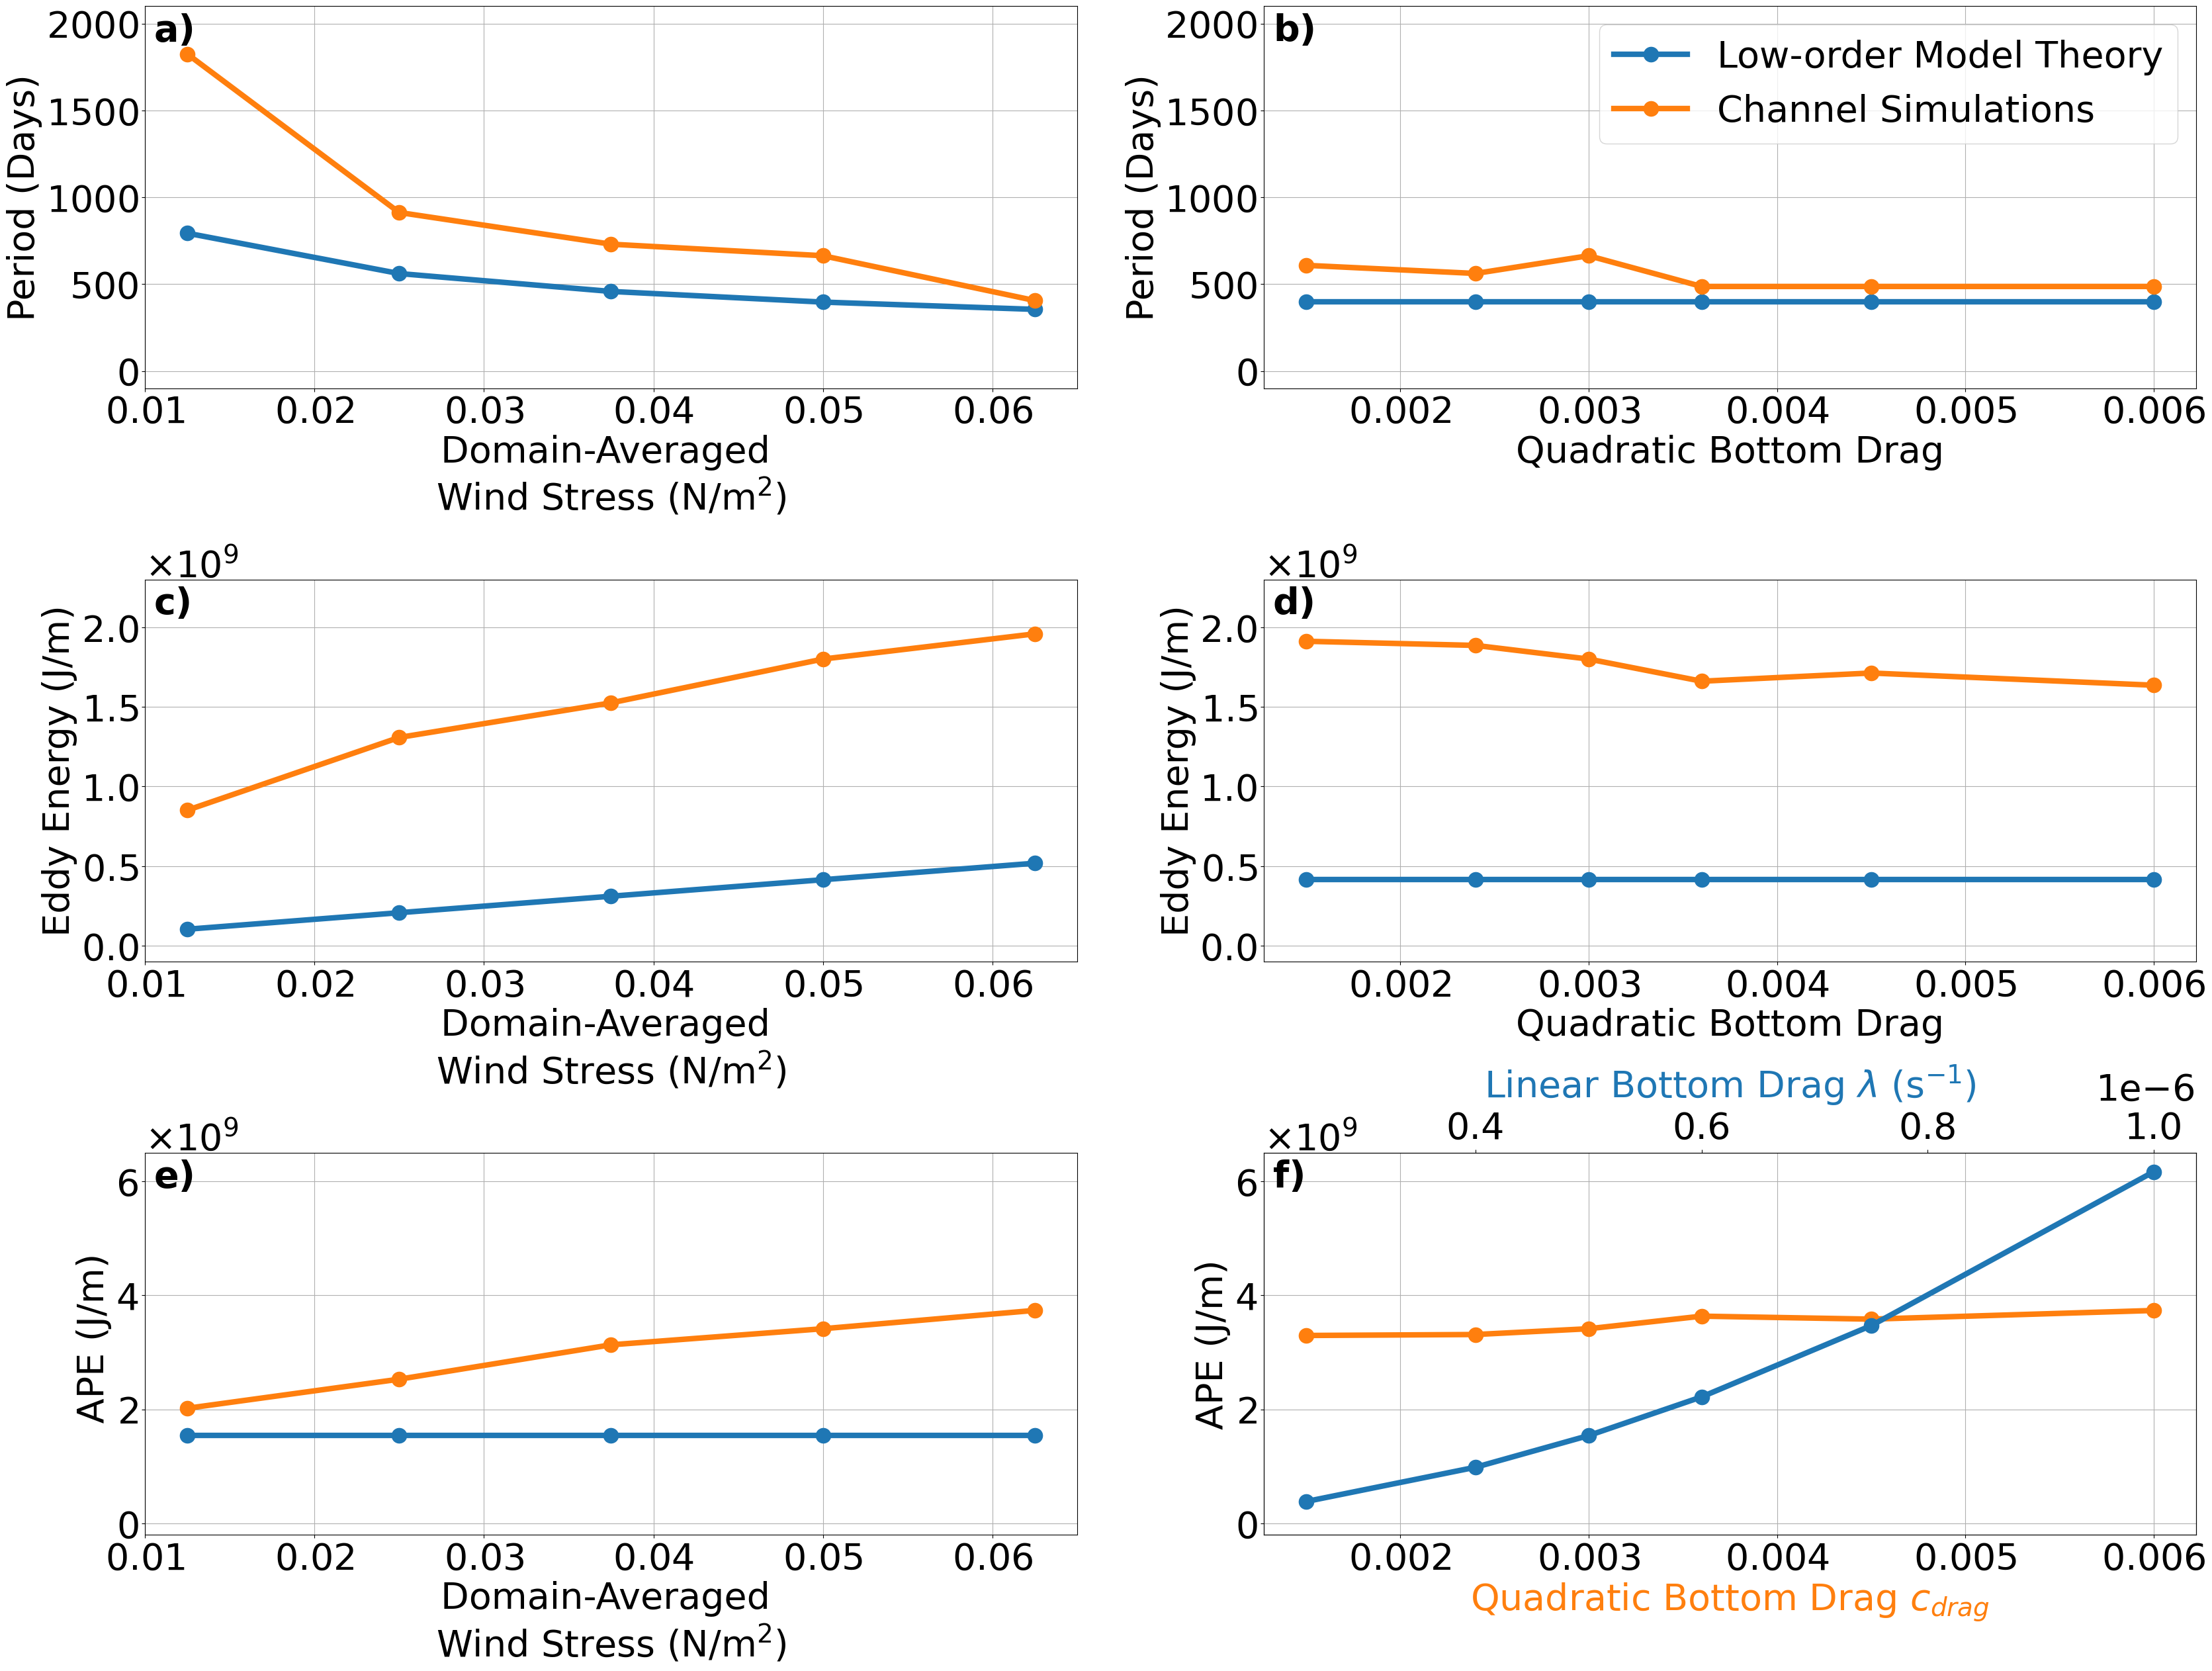

In [27]:
fig, axs = plt.subplots(3,2, figsize = (40,30))
lineweight = 6 #3 
mksize = 16 #10


tau_matrix = np.asarray([0.025,0.05,0.075,0.1, 0.125])/2
drag_matrix = np.asarray([cdrag_new*0.5,cdrag_new*0.8,cdrag_new,cdrag_new*1.2,cdrag_new*1.5,cdrag_new*2]) #crdag for linear low-order model
drag_plot_matrix = np.asarray([1.5e-3, 2.4e-3,3e-3,3.6e-3,4.5e-3,6e-3]) ## CHECK THE UNITS THAT EKE ARE IN IN THE DATA+BASE
Ly_matrix = np.asarray(np.ones(len(tau_matrix))*Ly)

#wind and period
T_matrix = [period(tau_matrix[i], Ly_matrix[i]) for i in range(len(tau_matrix))]
axs[0,0].plot(tau_matrix, T_matrix, label = 'Low-order Model Theory', marker = 'o', lw = lineweight, markersize = mksize)
axs[0,0].plot(tau_matrix, period_CDW_wind_EKE, label = 'Channel Simulations', marker = 'o', lw = lineweight, markersize = mksize)
axs[0,0].set_ylabel('Period (Days)')
axs[0,0].set_xlabel('Domain-Averaged \nWind Stress (N/m$^{2}$)')
axs[0,0].grid(which  = 'both')
axs[0,0].set_ylim([-100,2100])
axs[0,0].annotate('a)', xy = (0.01,0.91), xytext = (0,0), textcoords = 'offset points', xycoords = 'axes fraction', fontweight = 'bold')
axs[0,0].ticklabel_format(useMathText=True)

#drag amd period
axs[0,1].plot(drag_plot_matrix, T*np.ones(len(drag_matrix)), label = 'Low-order Model Theory', marker = 'o', lw = lineweight, markersize = mksize)
axs[0,1].plot(drag_plot_matrix, period_CDW_drag_EKE, label = 'Channel Simulations', marker = 'o', lw = lineweight, markersize = mksize)
axs[0,1].set_ylabel('Period (Days)')
axs[0,1].set_xlabel('Quadratic Bottom Drag')
axs[0,1].grid(which  = 'both')
axs[0,1].legend()
axs[0,1].set_ylim([-100,2100])
axs[0,1].annotate('b)', xy = (0.01,0.91), xytext = (0,0), textcoords = 'offset points', xycoords = 'axes fraction', fontweight = 'bold')
axs[0,1].ticklabel_format(useMathText=True)

#wind and E
T_matrix = [E_predict(tau_matrix[i]) for i in range(len(tau_matrix))]
axs[1,0].plot(tau_matrix, T_matrix,marker = 'o', label = 'Theory  (200km ASC)', lw = lineweight, markersize = mksize)
#plt.plot(tau_matrix, np.asarray([1.036231e+08,2.072461e+08,3.108692e+08,4.144923e+08,5.181154e+08]), label = 'Theory IVP (200km ASC)')

axs[1,0].plot(tau_matrix, E_wind, label = 'Experiments', marker = 'o', lw = lineweight, markersize = mksize)
axs[1,0].set_ylabel('Eddy Energy (J/m)')
axs[1,0].set_xlabel('Domain-Averaged \nWind Stress (N/m$^{2}$)')

axs[1,0].grid(which  = 'both')
#plt.ylim([-.1e9,3.4e9])
axs[1,0].set_ylim([-.1e9,2.3e9])
axs[1,0].annotate('c)', xy = (0.01,0.91), xytext = (0,0), textcoords = 'offset points', xycoords = 'axes fraction', fontweight = 'bold')
axs[1,0].ticklabel_format(useMathText=True)

#drag and E

Edrag_predict_matrix = np.ones(len(drag_matrix))*E_predict(0.1/2)
axs[1,1].plot(drag_plot_matrix, Edrag_predict_matrix, label = 'Theory (200km ASC)', marker = 'o', lw = lineweight, markersize = mksize)
#plt.plot(drag_matrix, np.ones(len(drag_matrix))*np.asarray([4.144923e+08]), label = 'Theory IVP (200km ASC)')

axs[1,1].plot(drag_plot_matrix, E_drag, label = 'Experiments', marker = 'o', lw = lineweight, markersize = mksize)
axs[1,1].set_ylabel('Eddy Energy (J/m)')
axs[1,1].set_xlabel('Quadratic Bottom Drag')
#plt.ylim([0,5e9])
axs[1,1].grid(which  = 'both')
axs[1,1].set_ylim([-.1e9,2.3e9])
axs[1,1].annotate('d)', xy = (0.01,0.91), xytext = (0,0), textcoords = 'offset points', xycoords = 'axes fraction', fontweight = 'bold')
axs[1,1].ticklabel_format(useMathText=True)


#wind and APE

T_matrix = np.ones(len(tau_matrix))*MAPE_predict(5e-7)

axs[2,0].plot(tau_matrix, T_matrix, label = 'Theory (200km ASC)', marker = 'o', color = 'C0', lw = lineweight, markersize = mksize)
axs[2,0].set_ylabel(' APE (J/m)')

axs[2,0].plot(tau_matrix, magnitude_wind_APE_cdw, label = 'Experiments', marker = 'o', color = 'C1', lw = lineweight, markersize = mksize)
axs[2,0].set_xlabel('Domain-Averaged \nWind Stress (N/m$^2$)')
axs[2,0].grid(which  = 'both')
axs[2,0].set_ylim([-0.2e9,6.5e9]) #4e9
axs[2,0].annotate('e)', xy = (0.01,0.91), xytext = (0,0), textcoords = 'offset points', xycoords = 'axes fraction', fontweight = 'bold')
axs[2,0].ticklabel_format(useMathText=True)

#drag and APE

APE_cdw_drag_predict_matrix = [MAPE_predict(drag_matrix[i]) for i in range(len(drag_matrix))] ## APE ~ O(1e7)
ax2 = axs[2,1].twiny()

ax2.plot(drag_matrix, APE_cdw_drag_predict_matrix, label = 'Theory (200km ASC)', marker = 'o', lw = lineweight, markersize = mksize)
axs[2,1].plot(drag_plot_matrix, magnitude_drag_APE_cdw, label = 'Experiments', marker = 'o', color = 'C1', lw = lineweight, markersize = mksize) #*1e6 is old APE cdw

axs[2,1].set_ylabel('APE (J/m)')
ax2.set_xlabel('Linear Bottom Drag $\lambda$ (s$^{-1}$)', color = 'C0', labelpad = 15)
axs[2,1].set_xlabel('Quadratic Bottom Drag $c_{drag}$', color = 'C1')
axs[2,1].grid(which  = 'both')
axs[2,1].set_ylim([-0.2e9,6.5e9])
axs[2,1].annotate('f)', xy = (0.01,0.91), xytext = (0,0), textcoords = 'offset points', xycoords = 'axes fraction', fontweight = 'bold')
axs[2,1].ticklabel_format(useMathText=True)

fig.subplots_adjust(wspace=0.2, hspace=0.5)

#plt.tight_layout()

plt.savefig('/g/data/v45/qo9901/layeredASFpaper_fig/Fig8_theory_simulation_compare_units.pdf')